In [1]:
# Import Dependencies

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook

import sys
sys.path.append("../new_notebooks/ipynb/dlp_opendata_api")
sys.path.append("../new_notebooks/ipynb")
from osf.image_api import image_reader_3d
from osf.particle_api import *
from osf.cluster_api import *

from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sparseconvnet as scn
import glob
import os.path as osp
import numpy as np

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

TESTSET_SIZE = 32
DELTA_V = 0.5
DELTA_D = 1.5

Welcome to JupyROOT 6.14/04


In [2]:
#ls /gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10
use_cuda = torch.cuda.is_available()
print(use_cuda)
n_cuda = torch.cuda.device_count()
print(n_cuda)

True
2


In [3]:
class UResNet(torch.nn.Module):
    def __init__(self, dim=3, size=192, nFeatures=16, depth=5, nClasses=5):
        import sparseconvnet as scn
        super(UResNet, self).__init__()
        #self._flags = flags
        dimension = dim
        reps = 2  # Conv block repetition factor
        kernel_size = 2  # Use input_spatial_size method for other values?
        m = nFeatures  # Unet number of features
        nPlanes = [i*m for i in range(1, depth+1)]  # UNet number of features per level
        # nPlanes = [(2**i) * m for i in range(1, num_strides+1)]  # UNet number of features per level
        nInputFeatures = 1
        self.sparseModel = scn.Sequential().add(
           scn.InputLayer(dimension, size, mode=3)).add(
           scn.SubmanifoldConvolution(dimension, nInputFeatures, m, 3, False)).add( # Kernel size 3, no bias
           scn.UNet(dimension, reps, nPlanes, residual_blocks=True, downsample=[kernel_size, 2])).add(  # downsample = [filter size, filter stride]
           scn.BatchNormReLU(m)).add(
           scn.OutputLayer(dimension))
        self.linear = torch.nn.Linear(m, nClasses)

    def forward(self, point_cloud):
        """
        point_cloud is a list of length minibatch size (assumes mbs = 1)
        point_cloud[0] has 3 spatial coordinates + 1 batch coordinate + 1 feature
        shape of point_cloud[0] = (N, 4)
        """
        #coords = point_cloud[:, 0:-1].float()
        #features = point_cloud[:, -1][:, None].float()
        x = self.sparseModel(point_cloud)
        x = self.linear(x)
        return x

In [4]:
def get_unet(fname, dimension=3, size=192, nFeatures=16, depth=5, nClasses=5):
    model = UResNet(dim=dimension, size=size, nFeatures=nFeatures, depth=depth, nClasses=nClasses)
    model = nn.DataParallel(model)
    #print(model.state_dict().keys())
    checkpoint = torch.load(fname, map_location='cpu')
    #print()
    #print(checkpoint['state_dict'].keys())
    model.load_state_dict(checkpoint['state_dict'], strict=True)
    # just return the pre-trained unet
    return model.module.sparseModel

In [5]:
class ClusteringAEData(Dataset):
    """
    A customized data loader for clustering.
    """
    def __init__(self, root, numPixels=192, filenames=None):
        """
        Initialize Clustering Dataset

        Inputs:
            - root: root directory of dataset
            - preload: if preload dataset into memory.
        """
        self.cluster_filenames = []
        self.energy_filenames = []
        self.root = root
        self.numPixels = str(numPixels)
        
        if filenames:
            self.energy_filenames = filenames[0]
            self.cluster_filenames = filenames[1]
            print(self.energy_filenames)

        self.energy_filenames.sort()
        self.cluster_filenames.sort()
        self.cluster_reader = cluster_reader(*self.cluster_filenames)
        self.energy_reader = image_reader_3d(*self.energy_filenames)
        self.len = self.energy_reader.entry_count()
        assert self.len == self.cluster_reader.entry_count()

    def __getitem__(self, index):
        """
        Get a sample from dataset.
        """
        voxel, ins_label = self.cluster_reader.get_image(index)
        _, energy, seg_label = self.energy_reader.get_image(index)
        voxel, ins_label = torch.from_numpy(voxel), torch.from_numpy(ins_label)
        seg_label = torch.from_numpy(seg_label)
        seg_label = torch.unsqueeze(seg_label, dim=1).type(torch.LongTensor)
        energy = torch.from_numpy(energy)
        energy = torch.unsqueeze(energy, dim=1)
        ins_label = torch.unsqueeze(ins_label, dim=1).type(torch.LongTensor)
        voxel = voxel.cuda()
        energy = energy.cuda()
        #with torch.no_grad():
        #    out = unet((voxel, energy))
        return (voxel, energy), ins_label, seg_label

    def __len__(self):
        """
        Total number of sampels in dataset.
        """
        return self.len

In [6]:
def ae_collate(batch):
    """
    Custom collate_fn for Autoencoder.
    """
    data = [item[0] for item in batch]
    ins_target = [item[1] for item in batch]
    seg_target = [item[2] for item in batch]
    return [data, ins_target, seg_target]

In [7]:
root = '/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10' #replace with your own path to root folder. 
trainset_cluster = [root + '/cluster/dlprod_cluster_192px_0{}.root'.format(i) for i in range(8)]
devset_cluster = [root + '/cluster/dlprod_cluster_192px_0{}.root'.format(8)]
#testset_cluster = [root + '/cluster/dlprod_cluster_192px_0{}.root'.format(9)]

trainset_energy = [root + '/dlprod_192px_0{}.root'.format(i) for i in range(8)]
devset_energy = [root + '/dlprod_192px_0{}.root'.format(8)]
#testset_energy = [root + '/dlprod_192px_0{}.root'.format(9)]

for i, f in enumerate(trainset_cluster):
    print(f)
    print(trainset_energy[i])
    
for i, f in enumerate(devset_cluster):
    print(f)
    print(devset_energy[i])
    
#for i, f in enumerate(testset_cluster):
#    print(f)
#    print(testset_energy[i])

trainset = ClusteringAEData(root, 192, filenames=[trainset_energy, trainset_cluster])
devset = ClusteringAEData(root, 192, filenames=[devset_energy, devset_cluster])
#testset = ClusteringAEData(root, 192, filenames=[testset_energy, testset_cluster])
print('Number of entries in training set: {}'.format(len(trainset)))
print('Number of entries in validation set: {}'.format(len(devset)))
#print('Number of entries in test set: {}'.format(len(testset)))

/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/cluster/dlprod_cluster_192px_00.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/dlprod_192px_00.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/cluster/dlprod_cluster_192px_01.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/dlprod_192px_01.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/cluster/dlprod_cluster_192px_02.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/dlprod_192px_02.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/cluster/dlprod_cluster_192px_03.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/dlprod_192px_03.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/cluster/dlprod_cluster_192px_04.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/dlprod_192px_04.root
/gpfs/slac/staas/fs1/g/neutrino/kterao/data/dlprod_ppn_v10/cluster/dlprod_cluster_192px_05.root
/gpfs/slac/staas/fs1/g/n

In [8]:
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, collate_fn=ae_collate, num_workers=8, pin_memory=False)
#devloader = DataLoader(devset, batch_size=1, shuffle=True, collate_fn=ae_collate, num_workers=0, pin_memory=False)

In [9]:
from loss import DiscriminativeLoss

In [10]:
criterion = DiscriminativeLoss(delta_var=DELTA_V, delta_dist=DELTA_D, multiclass=True, norm=2)

In [11]:
class ClusteringMLP(nn.Module):
    def __init__(self, input_dim=16, nHidden1=32, nHidden2=16, nClasses=3):
        super(ClusteringMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, nHidden1)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(nHidden1, nHidden2)
        nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(nHidden2, nClasses)
        nn.init.kaiming_normal_(self.fc3.weight)
        
        self.bn_1 = nn.BatchNorm1d(nHidden1)
        self.bn_2 = nn.BatchNorm1d(nHidden2)
        
    def forward(self, x):
        x = F.leaky_relu(self.bn_1(self.fc1(x)))
        x = F.leaky_relu(self.bn_2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [12]:
from sklearn.cluster import MeanShift, DBSCAN
from sklearn.metrics import adjusted_mutual_info_score , adjusted_rand_score

In [13]:
def accuracy(embedding, truth):
    '''
    Embedding = torch array with coordinates
    truth: truth labels torch for cluster assignments
    '''
    embed = embedding.cpu()
    embed = embed.detach().numpy()
    th = truth.numpy().squeeze()
    embed = np.atleast_1d(embed)
    th = np.atleast_1d(th)
    with torch.no_grad():
        clustering = MeanShift(bandwidth=DELTA_V, bin_seeding=True, cluster_all=True).fit_predict(embed)
        #clustering = DBSCAN(eps=DELTA_V).fit(embed)
        score = adjusted_rand_score(clustering, th)
        return score
    
def compute_accuracy_with_segmentation(embedding, truth, seg_labels):
    acc = []
    semantic_classes = seg_labels.unique()
    for sc in semantic_classes:
        index = (seg_labels == sc).squeeze(1).nonzero()
        index = index.squeeze(1)
        embedding_c, truth_c = embedding[index], truth[index]
        acc.append(accuracy(embedding_c, truth_c))
    return sum(acc) / float(len(acc))

In [15]:
fname = '/gpfs/slac/staas/fs1/g/neutrino/.scn_paper/new/sparse_is192_uns5_uf16_bs64/weights3/snapshot-29999.ckpt'
#unet = get_unet(fname)
unet = UResNet(nFeatures=16, nClasses=2)
unet = unet.cuda()
#unet = unet.eval()
print(unet)

UResNet(
  (sparseModel): Sequential(
    (0): InputLayer()
    (1): SubmanifoldConvolution 1->16 C3
    (2): Sequential(
      (0): ConcatTable(
        (0): Identity()
        (1): Sequential(
          (0): BatchNormReLU(16,eps=0.0001,momentum=0.9,affine=True)
          (1): SubmanifoldConvolution 16->16 C3
          (2): BatchNormReLU(16,eps=0.0001,momentum=0.9,affine=True)
          (3): SubmanifoldConvolution 16->16 C3
        )
      )
      (1): AddTable()
      (2): ConcatTable(
        (0): Identity()
        (1): Sequential(
          (0): BatchNormReLU(16,eps=0.0001,momentum=0.9,affine=True)
          (1): SubmanifoldConvolution 16->16 C3
          (2): BatchNormReLU(16,eps=0.0001,momentum=0.9,affine=True)
          (3): SubmanifoldConvolution 16->16 C3
        )
      )
      (3): AddTable()
      (4): ConcatTable(
        (0): Identity()
        (1): Sequential(
          (0): BatchNormReLU(16,eps=0.0001,momentum=0.9,affine=True)
          (1): Convolution 16->32 C2/2
   

In [15]:
data, ins_label, seg_label = trainset[0]
print(data[0].shape)
print(ins_label.shape)
print(seg_label.shape)
print(ins_label.unique())
print(seg_label.unique())
x,y = data

torch.Size([3827, 3])
torch.Size([3827, 1])
torch.Size([3827, 1])
tensor([ 0, 14])
tensor([0, 2])


In [16]:
print(x,y)
out = unet((x, y))
criterion = criterion.cuda()

print(out.shape)
print(criterion(out, ins_label, seg_labels=seg_label))
print(compute_accuracy_with_segmentation(out, ins_label, seg_label))

(tensor([[ 97,  42,   5],
        [ 93,  41,   9],
        [ 92,  42,   9],
        ...,
        [ 81,  61, 191],
        [ 82,  61, 191],
        [ 83,  61, 191]], device='cuda:0', dtype=torch.int32), tensor([[0.0156],
        [0.0139],
        [0.0264],
        ...,
        [0.0386],
        [0.0676],
        [0.0144]], device='cuda:0'))
torch.Size([3827, 2])
tensor(0.5573, device='cuda:0', grad_fn=<AddBackward0>)
0.5


In [17]:
import csv
f_train = open('train.csv', 'w')
trainWriter = csv.writer(f_train, delimiter=',')
f_dev = open('dev.csv', 'w')
devWriter = csv.writer(f_dev, delimiter=',')

In [18]:
training_epochs=100
#training_epoch=scn.checkpoint_restore(unet,exp_name,'unet',use_cuda)
optimizer = optim.Adam(unet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
print('#classifer parameters', sum([x.nelement() for x in unet.parameters()]))

#load_checkpoint('checkpoint10.ckpt', unet, optimizer)

('#classifer parameters', 2741426)


In [19]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [20]:
dev_index = list(np.random.randint(0, 9999, 32))
train_index = list(np.random.randint(0, 79999, 128))

sampler = torch.utils.data.sampler.SubsetRandomSampler(dev_index)
devloader = DataLoader(devset, sampler=sampler, batch_size=16, collate_fn=ae_collate)
sampler = torch.utils.data.sampler.SubsetRandomSampler(train_index)
train_small = DataLoader(trainset, sampler=sampler, batch_size=16, collate_fn=ae_collate)

In [21]:
def test(model, devloader, finetune=None):
    model.eval()
    test_loss = 0
    test_acc = 0
    count = 0
    with torch.no_grad():
        for k, batch in enumerate(devloader):
            x_batch = batch[0]
            ins_labels = batch[1]
            seg_labels = batch[2]
            for j, data in enumerate(x_batch):
                out = model(data)
                loss = criterion(out, ins_labels[j], seg_labels=seg_labels[j])
                acc = compute_accuracy_with_segmentation(out, ins_labels[j], seg_labels[j])
                test_loss += loss
                test_acc += acc
                count += 1
    print("Testing Count = {}".format(count))
    return test_loss.item() / float(TESTSET_SIZE), test_acc / float(TESTSET_SIZE)

In [23]:
import time

#trainset_len = len(trainset)
length = len(train_small.dataset)

for epoch in range(1, training_epochs+1):
    print("Epoch = {}".format(epoch))
    for i,batch in enumerate(train_small):
#        try:
        train_loss, train_acc = [], []
        unet.train()
        #model.train()
        optimizer.zero_grad()
        inputs, ins_labels, seg_labels = batch
        for j, data in enumerate(inputs):
            out = unet(data)
            loss = criterion(out, ins_labels[j], seg_labels=seg_labels[j])
            train_loss.append(loss)
            acc = compute_accuracy_with_segmentation(out, ins_labels[j], seg_labels[j])
            train_acc.append(acc)
        train_loss = sum(train_loss) / float(len(inputs))
        train_acc = sum(train_acc) / float(len(inputs))
        train_loss.backward()
        optimizer.step()
        print("Examples = {}/{}, Loss = {}, Acc = {}".format((i+1) * len(inputs), length, train_loss, train_acc))
        trainWriter.writerow([loss.item(), acc])
        f_train.flush()
        if i % 100 == 0:
            with torch.no_grad():
                dev_loss, dev_acc = test(unet, devloader)
                print("Devset Loss = {}, Acc = {}".format(dev_loss, dev_acc))
                devWriter.writerow([dev_loss, dev_acc])
                f_dev.flush()
    scheduler.step(train_loss)
#        except:
#            print("Warning: Error Encounterd!!")
#            continue
    if epoch % 10 == 0:
        save_checkpoint('checkpoint{}.ckpt'.format(epoch), unet, optimizer)
#scn.checkpoint_save(unet,exp_name,'unet',epoch, use_cuda)

Epoch = 1
Examples = 16/80000, Loss = 15.8618688583, Acc = 0.17862617675


/usr/local/lib/python2.7/dist-packages/sklearn/cluster/mean_shift_.py:292: UserWarning: Binning data failed with provided bin_size=0.500000, using data points as seeds.
  " using data points as seeds." % bin_size)


Testing Count = 32
Devset Loss = 16.1487979889, Acc = 0.282282352402
Examples = 32/80000, Loss = 10.8828344345, Acc = 0.254615027431
Examples = 48/80000, Loss = 10.6102018356, Acc = 0.238284007776
Examples = 64/80000, Loss = 9.37954998016, Acc = 0.252913642033
Examples = 80/80000, Loss = 8.54396915436, Acc = 0.210126617741
Examples = 96/80000, Loss = 10.680814743, Acc = 0.224644724921
Examples = 112/80000, Loss = 8.9968957901, Acc = 0.327420240745
Examples = 128/80000, Loss = 11.3685655594, Acc = 0.339464524739
Epoch = 2
Examples = 16/80000, Loss = 8.89296722412, Acc = 0.265443972047
Testing Count = 32
Devset Loss = 37.1517829895, Acc = 0.262365698249
Examples = 32/80000, Loss = 9.91884899139, Acc = 0.382645939675
Examples = 48/80000, Loss = 8.33980560303, Acc = 0.219734767267
Examples = 64/80000, Loss = 7.48395204544, Acc = 0.333429441461
Examples = 80/80000, Loss = 9.44234657288, Acc = 0.139849434746
Examples = 96/80000, Loss = 9.27744102478, Acc = 0.338793094261
Examples = 112/80000

Examples = 16/80000, Loss = 0.926245212555, Acc = 0.479509890653
Testing Count = 32
Devset Loss = 6.62795495987, Acc = 0.256958244936
Examples = 32/80000, Loss = 0.604001641273, Acc = 0.398267395652
Examples = 48/80000, Loss = 0.691306829453, Acc = 0.372735959424
Examples = 64/80000, Loss = 0.355494201183, Acc = 0.290597432105
Examples = 80/80000, Loss = 1.16100811958, Acc = 0.472641024317
Examples = 96/80000, Loss = 0.765848636627, Acc = 0.509717762187
Examples = 112/80000, Loss = 0.796946883202, Acc = 0.35587132926
Examples = 128/80000, Loss = 1.09002542496, Acc = 0.424401232994
Epoch = 16
Examples = 16/80000, Loss = 0.839284658432, Acc = 0.383328651652
Testing Count = 32
Devset Loss = 6.93241691589, Acc = 0.273431061889
Examples = 32/80000, Loss = 0.608282864094, Acc = 0.433848661143
Examples = 48/80000, Loss = 0.589178204536, Acc = 0.444899919111
Examples = 64/80000, Loss = 0.557517886162, Acc = 0.396115620597
Examples = 80/80000, Loss = 0.813601255417, Acc = 0.4656292816
Examples 

Examples = 96/80000, Loss = 0.330680429935, Acc = 0.497117176424
Examples = 112/80000, Loss = 0.30732473731, Acc = 0.504902281475
Examples = 128/80000, Loss = 0.215300783515, Acc = 0.509232707906
Epoch = 29
Examples = 16/80000, Loss = 0.343217015266, Acc = 0.608408776482
Testing Count = 32
Devset Loss = 6.85290956497, Acc = 0.249189136539
Examples = 32/80000, Loss = 0.515061199665, Acc = 0.614075231693
Examples = 48/80000, Loss = 0.367673516273, Acc = 0.559588245888
Examples = 64/80000, Loss = 0.179158702493, Acc = 0.408146750819
Examples = 80/80000, Loss = 0.181274071336, Acc = 0.390483015492
Examples = 96/80000, Loss = 0.273698747158, Acc = 0.486448922283
Examples = 112/80000, Loss = 0.389771133661, Acc = 0.50276229219
Examples = 128/80000, Loss = 0.309490591288, Acc = 0.510861132402
Epoch = 30
Examples = 16/80000, Loss = 0.199695304036, Acc = 0.496485076407
Testing Count = 32
Devset Loss = 6.61428546906, Acc = 0.209172176473
Examples = 32/80000, Loss = 0.457814455032, Acc = 0.579301

Examples = 32/80000, Loss = 0.243044227362, Acc = 0.572678853904
Examples = 48/80000, Loss = 0.202276721597, Acc = 0.397306122456
Examples = 64/80000, Loss = 0.182657331228, Acc = 0.387643630965
Examples = 80/80000, Loss = 0.120280556381, Acc = 0.553801587143
Examples = 96/80000, Loss = 0.216451436281, Acc = 0.584313400482
Examples = 112/80000, Loss = 0.285516113043, Acc = 0.562555966742
Examples = 128/80000, Loss = 0.176384985447, Acc = 0.566681048303
Epoch = 43
Examples = 16/80000, Loss = 0.174391075969, Acc = 0.478699083143
Testing Count = 32
Devset Loss = 6.46968460083, Acc = 0.238182484989
Examples = 32/80000, Loss = 0.318986952305, Acc = 0.528621391886
Examples = 48/80000, Loss = 0.256893575191, Acc = 0.563934771707
Examples = 64/80000, Loss = 0.176090016961, Acc = 0.536106951582
Examples = 80/80000, Loss = 0.168641850352, Acc = 0.65283848962
Examples = 96/80000, Loss = 0.20067755878, Acc = 0.507144855113
Examples = 112/80000, Loss = 0.18202021718, Acc = 0.523619589137
Examples =

Examples = 128/80000, Loss = 0.166219472885, Acc = 0.62202711668
Epoch = 56
Examples = 16/80000, Loss = 0.17902430892, Acc = 0.514272337747
Testing Count = 32
Devset Loss = 7.31790685654, Acc = 0.209287029578
Examples = 32/80000, Loss = 0.29613250494, Acc = 0.539054445891
Examples = 48/80000, Loss = 0.228774353862, Acc = 0.576884178602
Examples = 64/80000, Loss = 0.292315661907, Acc = 0.673741828599
Examples = 80/80000, Loss = 0.126417815685, Acc = 0.511563338723
Examples = 96/80000, Loss = 0.0933838486671, Acc = 0.463286873426
Examples = 112/80000, Loss = 0.100099816918, Acc = 0.526844532625
Examples = 128/80000, Loss = 0.146516412497, Acc = 0.56152898039
Epoch = 57
Examples = 16/80000, Loss = 0.135185688734, Acc = 0.59200880926
Testing Count = 32
Devset Loss = 7.03615570068, Acc = 0.235613165354
Examples = 32/80000, Loss = 0.157998263836, Acc = 0.612685729522
Examples = 48/80000, Loss = 0.171356528997, Acc = 0.647901843217
Examples = 64/80000, Loss = 0.269272238016, Acc = 0.511162401

Examples = 80/80000, Loss = 0.274907439947, Acc = 0.6029139218
Examples = 96/80000, Loss = 0.155736774206, Acc = 0.619253037816
Examples = 112/80000, Loss = 0.127030640841, Acc = 0.434612298574
Examples = 128/80000, Loss = 0.173653319478, Acc = 0.621689805041
Epoch = 70
Examples = 16/80000, Loss = 0.278615564108, Acc = 0.558803059733
Testing Count = 32
Devset Loss = 7.05023097992, Acc = 0.206875679681
Examples = 32/80000, Loss = 0.155269175768, Acc = 0.464256825655
Examples = 48/80000, Loss = 0.118047095835, Acc = 0.469721291063
Examples = 64/80000, Loss = 0.175612822175, Acc = 0.620783193146
Examples = 80/80000, Loss = 0.255567640066, Acc = 0.605066126939
Examples = 96/80000, Loss = 0.121234990656, Acc = 0.479488528746
Examples = 112/80000, Loss = 0.138543441892, Acc = 0.555863851683
Examples = 128/80000, Loss = 0.218478918076, Acc = 0.578423328071
model saved to checkpoint70.ckpt
Epoch = 71
Examples = 16/80000, Loss = 0.114624015987, Acc = 0.65041879837
Testing Count = 32
Devset Loss

KeyboardInterrupt: 

Error in <TTreeCache::FillBuffer>: Inconsistency: fCurrentClusterStart=1976 fEntryCurrent=3820 fNextClusterStart=3952 but fCurrentEntry should not be in between the two
Error in <TTreeCache::FillBuffer>: Inconsistency: fCurrentClusterStart=2186 fEntryCurrent=3186 fNextClusterStart=3279 but fCurrentEntry should not be in between the two
Error in <TTreeCache::FillBuffer>: Inconsistency: fCurrentClusterStart=2176 fEntryCurrent=6423 fNextClusterStart=6528 but fCurrentEntry should not be in between the two
Error in <TTreeCache::FillBuffer>: Inconsistency: fCurrentClusterStart=2203 fEntryCurrent=6492 fNextClusterStart=6609 but fCurrentEntry should not be in between the two
Error in <TTreeCache::FillBuffer>: Inconsistency: fCurrentClusterStart=2179 fEntryCurrent=6498 fNextClusterStart=6537 but fCurrentEntry should not be in between the two
Error in <TTreeCache::FillBuffer>: Inconsistency: fCurrentClusterStart=4388 fEntryCurrent=6456 fNextClusterStart=6582 but fCurrentEntry should not be in be

In [24]:
train_index

[46524,
 22772,
 52740,
 14537,
 1501,
 72084,
 58633,
 47759,
 45927,
 40443,
 42794,
 70386,
 14629,
 52596,
 73634,
 24795,
 23451,
 21868,
 72341,
 73108,
 71866,
 51190,
 34244,
 39200,
 46402,
 54638,
 52766,
 27453,
 31168,
 64,
 59743,
 62271,
 1597,
 44291,
 73196,
 7039,
 62491,
 12537,
 48142,
 2145,
 18244,
 13517,
 73282,
 14315,
 79421,
 40563,
 32989,
 55348,
 18596,
 17531,
 1803,
 29955,
 22991,
 63472,
 67574,
 65229,
 30715,
 35280,
 26568,
 10448,
 69625,
 41247,
 71191,
 30021,
 68293,
 45437,
 48734,
 44038,
 29207,
 47294,
 26880,
 29135,
 42737,
 9961,
 54407,
 15500,
 53550,
 9188,
 7494,
 40733,
 77917,
 41368,
 12268,
 76066,
 45658,
 70525,
 18423,
 56017,
 77514,
 76877,
 77517,
 65559,
 29922,
 17954,
 16893,
 21747,
 56289,
 52742,
 33444,
 30875,
 43253,
 67828,
 68753,
 38910,
 3772,
 76692,
 44809,
 1358,
 32570,
 11488,
 68088,
 27586,
 29642,
 1325,
 44306,
 63794,
 72834,
 26208,
 61774,
 64009,
 37130,
 5534,
 26398,
 68415,
 32463,
 57541,
 37486,

In [25]:
dev_index

[2522,
 5620,
 4641,
 6079,
 9774,
 603,
 7545,
 4291,
 9502,
 2047,
 2335,
 7528,
 8548,
 3609,
 4099,
 4197,
 1846,
 5286,
 8922,
 6968,
 4657,
 2519,
 6019,
 7103,
 4849,
 5668,
 7277,
 2787,
 5474,
 9744,
 1306,
 3404]

In [26]:
from localutil.data import *
from localutil.visualization import *
from plotly.offline import init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
#import plotly.io as pio

In [27]:
# Code by Brad Nelson, I redefine the localutil.visualization modules 
# for better pictures (I set size of markers = 1)

def scatter_energy(img_reader, n, threshold=0.0):
    """
    Creates graph object for energy scatter plot
    Args:
        img_reader (image_reader_3d)
        n (int): image to plot
        threshold (optional): threshold energies below a certain value
    """
    voxels, energy, labels = img_reader.get_image(n)
    inds = energy > threshold
    trace = go.Scatter3d(x=voxels[inds,0], y=voxels[inds,1], z=voxels[inds,2],
                    mode='markers',
                    marker = dict(
                        size = 1,
                        color = np.log(energy[inds]),
                        colorscale='Viridis',
                        opacity=0.8
                    ), hovertext=energy)
    return trace

def scatter_classes(img_reader, n):
    voxels, types = img_reader.get_image(n)
    trace = go.Scatter3d(x=voxels[:,0], y=voxels[:,1], z=voxels[:,2],
                    mode='markers',
                    marker = dict(
                        size = 1,
                        color = types,
                        colorscale='Viridis',
                        opacity=0.8
                    ), hovertext=types)
    return trace

def scatter_clusters(voxels, clusters):
    trace = go.Scatter3d(x=voxels[:,0], y=voxels[:,1], z=voxels[:,2],
                    mode='markers',
                    marker = dict(
                        size = 1,
                        color = clusters,
                        colorscale='Viridis',
                        opacity=0.8
                    ), hovertext=clusters)
    return trace

In [124]:
# 22772 for good eventexample
eventn = 22772
trace1 = scatter_classes(trainset.cluster_reader, eventn)
trace2 = scatter_energy(trainset.energy_reader, eventn)
fig = go.Figure(data=[trace1])
iplot(fig)
#pio.write_image(fig, 'images/fig1.pdf')

In [544]:
data, clabel, slabel = trainset[22772]

In [545]:
embed = unet(data)

In [546]:
semantic_classes = slabel.unique()

In [547]:
semantic_classes

tensor([3, 1, 2])

In [548]:
cluster_labels = clabel.unique()
cluster_labels

tensor([ 8, 28,  1, 11, 33,  3, 12,  0, 21, 30, 13])

In [549]:
def accuracy(embedding, truth):
    '''
    Embedding = torch array with coordinates
    truth: truth labels torch for cluster assignments
    '''
    embed = embedding.cpu()
    embed = embed.detach().numpy()
    th = truth.numpy().squeeze()
    embed = np.atleast_1d(embed)
    th = np.atleast_1d(th)
    with torch.no_grad():
        clustering = MeanShift(bandwidth=DELTA_V, bin_seeding=True, cluster_all=True).fit_predict(embed)
        #clustering = DBSCAN(eps=DELTA_V).fit(embed)
        score = adjusted_rand_score(clustering, th)
        return score, clustering

In [550]:
coords = embed.cpu().detach().numpy()

In [551]:
x = coords[:, 0]
y = coords[:, 1]

In [552]:
z = clabel.numpy()

In [553]:
z = z.squeeze()
print(np.unique(slabel))

[1 2 3]


In [559]:
index = (slabel == 1).squeeze(1).nonzero()
index = index.squeeze(1)
embedding_c, truth_c = embed[index], clabel[index]

In [560]:
acc, clusters = accuracy(embedding_c, truth_c)
print(acc)

0.865553450122


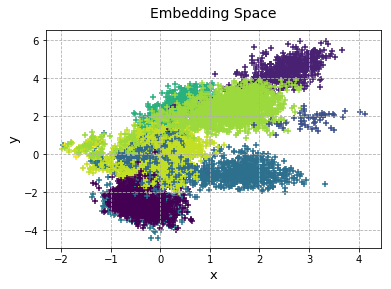

In [561]:
#colors = ['navy','purple','yellow']
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.scatter(x,y, c=z, cmap=matplotlib.pyplot.viridis(), marker='+', alpha=1)
ax.set_xlabel('x', fontsize=13)
ax.set_ylabel('y', fontsize=13)
ax.set_title('Embedding Space'.format(acc), y=1.03, fontsize=14)
plt.show()
plt.close()

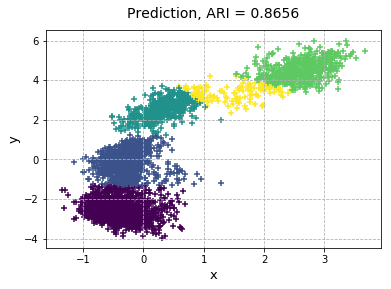

In [562]:
#colors = ['navy','purple','yellow']
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.scatter(x[index],y[index], c=clusters, cmap=matplotlib.pyplot.viridis(), marker='+', alpha=1)
ax.set_xlabel('x', fontsize=13)
ax.set_ylabel('y', fontsize=13)
ax.set_title('Prediction, ARI = {:.4f}'.format(acc), y=1.03, fontsize=14)
plt.show()
plt.close()

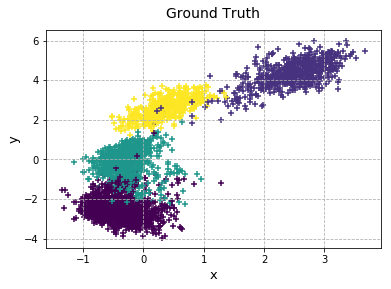

In [563]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.scatter(x[index],y[index], c=z[index], cmap=matplotlib.pyplot.viridis(), marker='+', alpha=1)
ax.set_xlabel('x', fontsize=13)
ax.set_ylabel('y', fontsize=13)
ax.set_title('Ground Truth'.format(acc), y=1.03, fontsize=14)
plt.show()
plt.close()

In [564]:
clusters.size

3974

In [532]:
index = index.numpy()

In [533]:
z

array([13, 30, 30, ..., 28, 28, 28])

In [534]:
import matplotlib

In [535]:
voxels, types = data[0].cpu().detach().numpy(), z
trace = go.Scatter3d(x=voxels[:,0][index], y=voxels[:,1][index], z=voxels[:,2][index],
                mode='markers',
                marker = dict(
                    size = 1,
                    color = clusters,
                    colorscale='Viridis',
                    opacity=0.8
                ), hovertext=clusters)
fig = go.Figure(data=[trace])
iplot(fig)

In [525]:
acc

0.8161611243447233

AttributeError: 'Figure' object has no attribute 'close'

In [565]:
unet = unet.eval()
d = {}
with torch.no_grad():
    for i in train_index:
        print("index = {}".format(i))
        data, clabel, slabel = trainset[i]
        embed = unet(data)
        coords = embed.cpu().detach().numpy()
        classes = np.unique(slabel)
        for s in classes:
            if s not in d:
                d[s] = []
            index = (slabel == s).squeeze(1).nonzero()
            index = index.squeeze(1)
            embedding_c, truth_c = embed[index], clabel[index]
            acc, _ = accuracy(embedding_c, truth_c)
            print("Class = {}, Acc = {}".format(s, acc))
            d[s].append(acc)

index = 46524
Class = 0, Acc = 0.0
Class = 1, Acc = 0.40921980401
Class = 2, Acc = 0.0
index = 22772
Class = 1, Acc = 0.865553450122
Class = 2, Acc = 0.697300257839
Class = 3, Acc = 1.0
index = 52740
Class = 0, Acc = 0.0
Class = 1, Acc = 0.756994837963
Class = 2, Acc = 0.782792638418
index = 14537
Class = 0, Acc = 1.0
Class = 2, Acc = 0.218785540764
index = 1501
Class = 1, Acc = 0.690882324969
Class = 2, Acc = 0.36986535284
Class = 3, Acc = 0.1776132444
index = 72084
Class = 0, Acc = 1.0
Class = 1, Acc = 0.970022265407
Class = 2, Acc = 0.21096178463
Class = 3, Acc = 0.374242932608
index = 58633
Class = 0, Acc = 0.0
Class = 1, Acc = 0.937351175648
Class = 2, Acc = 0.524429421703
Class = 3, Acc = 1.0
index = 47759
Class = 1, Acc = 0.578403071628
Class = 2, Acc = 0.669042292349
Class = 3, Acc = 0.0
index = 45927
Class = 0, Acc = 0.875523064664
Class = 1, Acc = 0.458420049088
Class = 2, Acc = 0.607285662346
index = 40443
Class = 0, Acc = 0.0
Class = 1, Acc = 0.33921651759
Class = 2, Acc = 

Class = 1, Acc = 0.340910600385
Class = 2, Acc = 0.0
index = 76877
Class = 0, Acc = 1.0
Class = 1, Acc = 0.9037204056
Class = 2, Acc = 0.773198299693
Class = 4, Acc = 0.0
index = 77517
Class = 1, Acc = 0.633465638117
Class = 3, Acc = 0.0
index = 65559
Class = 0, Acc = 0.0253742096466
Class = 1, Acc = 0.16820645008
Class = 2, Acc = 0.301861025252
Class = 4, Acc = 0.0
index = 29922
Class = 0, Acc = 0.950301878188
Class = 1, Acc = 0.787891625105
Class = 2, Acc = 0.344926377833
Class = 4, Acc = 0.0
index = 17954
Class = 1, Acc = 1.0
Class = 2, Acc = 0.0
index = 16893
Class = 1, Acc = 0.921581865584
Class = 2, Acc = 0.662518337295
Class = 3, Acc = 1.0
index = 21747
Class = 0, Acc = 1.0
Class = 1, Acc = 0.0
Class = 2, Acc = 0.517691803914
index = 56289
Class = 0, Acc = 0.77335394824
Class = 1, Acc = 0.0
Class = 2, Acc = 0.0273117338856
Class = 3, Acc = 0.877310971536
index = 52742
Class = 0, Acc = 0.271537824165
Class = 1, Acc = 0.391185349101
Class = 2, Acc = 0.276851322216
index = 33444
Cl

In [567]:
acc_0 = np.asarray(d[0])
acc_1 = np.asarray(d[1])
acc_2 = np.asarray(d[2])
acc_3 = np.asarray(d[3])
acc_4 = np.asarray(d[4])

In [568]:
d.keys()

[0, 1, 2, 3, 4]

In [570]:
np.mean(acc_0)

0.48425641811351205

In [571]:
np.mean(acc_1)

0.5736263410564129

In [572]:
np.mean(acc_2)

0.3395122641997184

In [573]:
np.mean(acc_3)

0.3984681570854

In [574]:
np.mean(acc_4)

0.13291850273933858